# Object detection using YOLO in keras

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

In [3]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.2 MB/s eta 0:00:00


In [4]:
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

In [5]:
dataset_path = "/content/drive/MyDrive/data_object_detection_yolo"
save_path = "/content/drive/MyDrive/yolo_models/"

# Path to dataset
image_dir = f"{dataset_path}/images/train"
label_dir = f"{dataset_path}/labels/train"

class_mapping = {0: "fractured"}
MAX_BOXES = 5
bounding_box_format = "rel_xyxy"

In [6]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

without ragged constant

In [7]:
def parse_yolo_annotation(txt_file, image_dir):
    image_name = os.path.basename(txt_file).replace(".txt", ".jpg")
    image_path = os.path.join(image_dir, image_name)

    boxes = []
    class_ids = []

    with open(txt_file, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])

        # Convert YOLO -> [x_min, y_min, x_max, y_max] in relative coords
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        boxes.append([x_min, y_min, x_max, y_max])
        class_ids.append(class_id)

    # Convert to dense numpy
    boxes = np.array(boxes, dtype=np.float32)
    class_ids = np.array(class_ids, dtype=np.int32)

    # Pad or clip to MAX_BOXES
    num_boxes = len(boxes)
    padded_boxes = np.zeros((MAX_BOXES, 4), dtype=np.float32)
    padded_classes = np.zeros((MAX_BOXES,), dtype=np.int32)

    # If there are more than MAX_BOXES, clip them
    if num_boxes > MAX_BOXES:
        boxes = boxes[:MAX_BOXES]
        class_ids = class_ids[:MAX_BOXES]
        num_boxes = MAX_BOXES

    padded_boxes[:num_boxes] = boxes
    padded_classes[:num_boxes] = class_ids

    return image_path, padded_boxes, padded_classes

def create_tf_dataset(image_dir, label_dir):
    txt_files = sorted([os.path.join(label_dir, f)
                        for f in os.listdir(label_dir) if f.endswith(".txt")])

    image_paths = []
    all_boxes = []
    all_classes = []

    for txt_file in tqdm(txt_files):
        image_path, boxes, class_ids = parse_yolo_annotation(txt_file, image_dir)
        image_paths.append(image_path)
        all_boxes.append(boxes)      # shape [MAX_BOXES, 4]
        all_classes.append(class_ids) # shape [MAX_BOXES]

    image_paths = tf.convert_to_tensor(image_paths, dtype=tf.string)
    all_boxes = tf.convert_to_tensor(all_boxes, dtype=tf.float32)      # shape [num_images, MAX_BOXES, 4]
    all_classes = tf.convert_to_tensor(all_classes, dtype=tf.int32)    # shape [num_images, MAX_BOXES]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, all_boxes, all_classes))
    return dataset

def load_dataset(image_path, boxes, classes):
    # 1) Decode/resize the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (640, 640))
    image = tf.image.convert_image_dtype(image, tf.float32)

    # 2) Cast bounding box data
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),  # shape [MAX_BOXES]
        "boxes": tf.cast(boxes, dtype=tf.float32),      # shape [MAX_BOXES, 4]
    }
    return {
        "images": tf.cast(image, tf.float32),
        "bounding_boxes": bounding_boxes
    }


## Data Augmentation

KerasCV natively supports bounding box augmentation with specialized layers. These layers automatically adjust bounding box coordinates during image transformations, maintaining accuracy and alignment. This allows us to integrate data augmentation into object detection workflows, improving training and model performance.

In [8]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format=bounding_box_format),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format=bounding_box_format
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format=bounding_box_format
        ),
    ]
)

## Create the train, validation and test splits

In [9]:
# Paths for train, test, validation
split_folders = ["train", "test", "val"]
split_datasets = {}

# Loop through train, test, and validation and create separate datasets
for split in split_folders:
    image_dir = f"{dataset_path}/images/{split}"
    label_dir = f"{dataset_path}/labels/{split}"

    split_datasets[split] = create_tf_dataset(image_dir, label_dir)

for split in split_folders:
    split_datasets[split] = (
        split_datasets[split]
        .map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)  # Load images & bounding boxes ONCE
        .shuffle(BATCH_SIZE * 4)  # Shuffle before batching
    )
# ds = create_tf_dataset(image_dir, label_dir)
# ds = ds.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
# ds = ds.batch(batch_size=4).prefetch(tf.data.AUTOTUNE)

train_ds = split_datasets["train"].batch(BATCH_SIZE, drop_remainder=True)
# train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

val_ds = split_datasets["val"].batch(BATCH_SIZE, drop_remainder=True)
test_ds = split_datasets["test"].batch(BATCH_SIZE, drop_remainder=True)

100%|██████████| 82/82 [00:28<00:00,  2.90it/s]


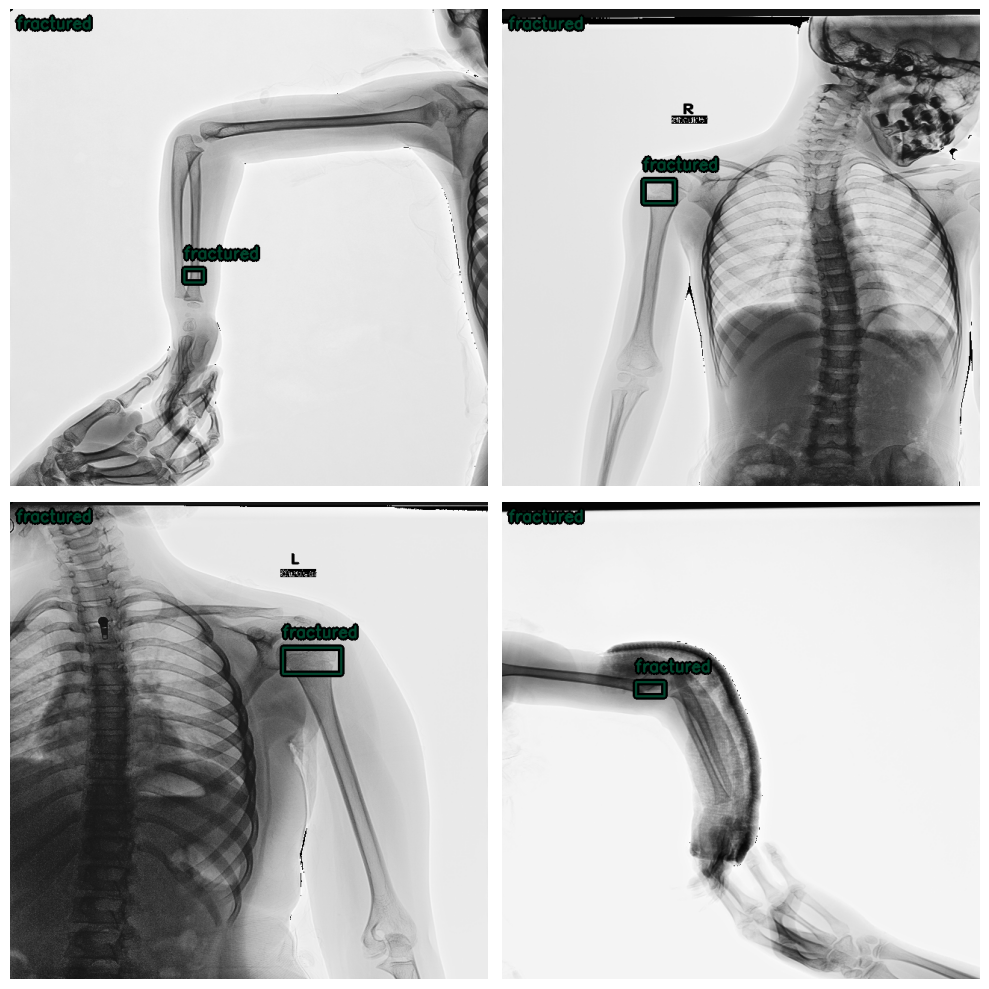

In [10]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format=bounding_box_format, value_range=(0, 1), rows=2, cols=2
)

We extract the inputs from the preprocessing dictionary and get them ready to be
fed into the model.

In [11]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

## Create the model

In [12]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

100%|██████████| 646/646 [00:00<00:00, 1.56MB/s]


100%|██████████| 19.7M/19.7M [00:00<00:00, 24.6MB/s]


**Model Configuration:**
The **YOLOv8 Detector** is used for object detection on X-ray images, specifically for identifying bone fractures. The model is initialized with the following parameters:

- `num_classes=1`: The dataset contains a single class (`fractured`).
- `backbone=backbone`: A pre-trained YOLOv8 backbone is used for feature extraction.
- `fpn_depth=2`: A **Feature Pyramid Network (FPN)** with depth 2 is applied, improving the detection of fractures at different scales by fusing shallow and deep features.

In [13]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format=bounding_box_format,
    backbone=backbone,
    fpn_depth=2,
)

1. Classification Loss: This loss function calculates the discrepancy between anticipated
class probabilities and actual class and we use
`binary_crossentropy` for this binary classification task.

2. Box Loss: `box_loss` is the loss function used to measure the difference between the
predicted bounding boxes and the ground truth.

In [14]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [15]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format=bounding_box_format,
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


In [16]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, f"{save_path}_keras_model.keras")],
)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - box_loss: 4.5627 - class_loss: 1005.3214 - loss: 1009.8842

InvalidArgumentError: {{function_node __wrapped__EagerPyFunc_Tin_1_Tout_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} ValueError: convert_format() must receive `images` or `image_shape` when transforming between relative and absolute formats.convert_format() received source=`<built-in function format>`, target=`<built-in function format>, but images=None and image_shape=None.
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/keras_cv/src/bounding_box/converters.py", line 426, in convert_format
    in_xyxy = to_xyxy_fn(boxes, images=images, image_shape=image_shape)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras_cv/src/bounding_box/converters.py", line 214, in _rel_xyxy_to_xyxy
    image_height, image_width = _image_shape(images, image_shape, boxes)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras_cv/src/bounding_box/converters.py", line 515, in _image_shape
    raise RequiresImagesException()

keras_cv.src.bounding_box.converters.RequiresImagesException


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 205, in result_on_host_cpu
    return tf.constant(obj_result(force), obj.dtype)
                       ^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 256, in result
    self._cached_result = self._compute_result()
                          ^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 263, in _compute_result
    metrics = compute_pycocotools_metric(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 286, in compute_pycocotools_metric
    box_pred = bounding_box.convert_format(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras_cv/src/backend/scope.py", line 37, in wrapper
    return function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras_cv/src/bounding_box/converters.py", line 429, in convert_format
    raise ValueError(

ValueError: convert_format() must receive `images` or `image_shape` when transforming between relative and absolute formats.convert_format() received source=`<built-in function format>`, target=`<built-in function format>, but images=None and image_shape=None.

 [Op:EagerPyFunc] name: 

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format=bounding_box_format)